# E-commerce Customers Segmentation

## Task:

- Develop and train an unsupervised machine learning 
model to segment customers based on their transactional behavior and other relevant feature 
from the dataset. The goal is to identify customer groups that share similar behaviors and u e
these segments to discuss strategies for offering coupons to increase loyalty and satisfaction.

### 1. Data Importing and Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
# Load data from Excel file
excel_file = 'E-commerce_data.xlsx'
transactions = pd.read_excel(excel_file, sheet_name='transactions')
customers = pd.read_excel(excel_file, sheet_name='customers')
genders = pd.read_excel(excel_file, sheet_name='genders')
cities = pd.read_excel(excel_file, sheet_name='cities')
branches = pd.read_excel(excel_file, sheet_name='branches')
merchants = pd.read_excel(excel_file, sheet_name='merchants')

### 2. Feature Selection

In [3]:
# Merge transactions with customers
merged_data = pd.merge(transactions, customers, on='customer_id', how='left')

In [4]:
# Merge with branches
merged_data = pd.merge(merged_data, branches, on='branch_id', how='left')

In [5]:
# Merge with merchants
merged_data = pd.merge(merged_data, merchants, on='merchant_id', how='left')

In [6]:
# Merge with genders
merged_data = pd.merge(merged_data, genders, on='gender_id', how='left')

In [7]:
# Merge with cities
merged_data = pd.merge(merged_data, cities, on='city_id', how='left')

merged_data.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,merchant_id,merchant_name,gender_name,city_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,2023-05-16,15,2,7,Berry-Anderson,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,14,2,9,"Campbell, Shaffer and Martinez",Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2022-05-30,2,1,7,Berry-Anderson,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,2023-11-27,15,2,18,Lewis LLC,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,14,1,15,Butler-Gomez,Male,Damietta


In [8]:
# Create coupon usage frequency and burned coupon frequency
coupon_usage = merged_data.groupby('customer_id')['transaction_id'].count().reset_index()
coupon_usage.columns = ['customer_id', 'coupon_usage_frequency']

coupon_usage.head()

,customer_id,coupon_usage_frequency
0,1,7
1,2,3
2,3,5
3,4,1
4,5,4
...,...,...
984,996,3
985,997,3
986,998,4
987,999,4


In [9]:
# Create burned coupon frequency (transaction_status = 'burned')
burned_coupons = merged_data[merged_data['transaction_status'] == 'burned'].groupby('customer_id')['transaction_id'].count().reset_index()
burned_coupons.columns = ['customer_id', 'burned_coupon_count']

burned_coupons

,customer_id,burned_coupon_count
0,1,3
1,2,1
2,3,1
3,5,3
4,6,4
...,...,...
904,995,2
905,997,1
906,998,3
907,999,4


In [10]:
# Merge these features back to the main dataframe
segmentation_data = pd.merge(coupon_usage, burned_coupons, on='customer_id', how='left')

segmentation_data

,customer_id,coupon_usage_frequency,burned_coupon_count
0,1,7,3.0
1,2,3,1.0
2,3,5,1.0
3,4,1,NaN
4,5,4,3.0
...,...,...,...
984,996,3,NaN
985,997,3,1.0
986,998,4,3.0
987,999,4,4.0


In [11]:
# Fill missing values with 0 (for customers who never burned a coupon)
segmentation_data['burned_coupon_count'] = segmentation_data['burned_coupon_count'].fillna(0)

In [12]:
# Add demographic features like gender and city
segmentation_data = pd.merge(segmentation_data, merged_data[['customer_id', 'gender_name', 'city_name']].drop_duplicates(), on='customer_id', how='left')

### 3. Model Development

In [13]:
# Select relevant features for clustering
X = segmentation_data[['coupon_usage_frequency', 'burned_coupon_count']]

In [14]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply KMeans with a range of clusters and evaluate the elbow method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

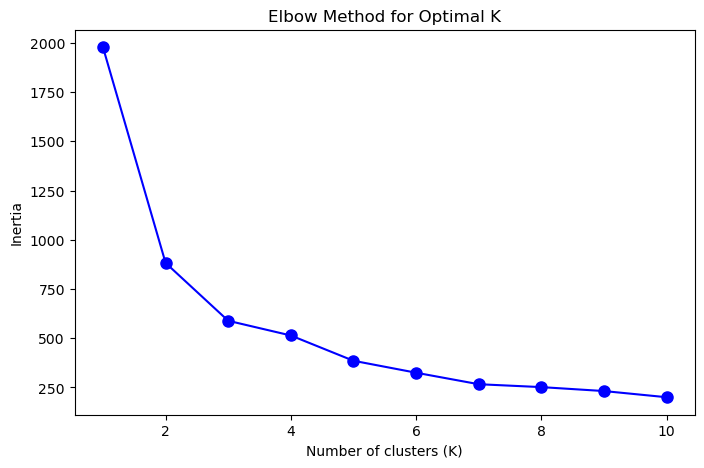

In [16]:
# Step 5: Visualize the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
# Step 6: Apply KMeans with the optimal number of clusters (based on elbow curve)
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
segmentation_data['cluster'] = kmeans.fit_predict(X_scaled)

### 4. Model Evaluation

In [18]:
# Silhouette Score
silhouette_avg = silhouette_score(X_scaled, segmentation_data['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.40166997511693786


### 5. Visualizing the Clusters

In [19]:
# Centroids are in the scaled space, so inverse transform them to the original space
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

In [20]:
# Convert the centroids to a DataFrame for plotting
centroids_df = pd.DataFrame(centroids_original, columns=['coupon_usage_frequency', 'burned_coupon_count'])

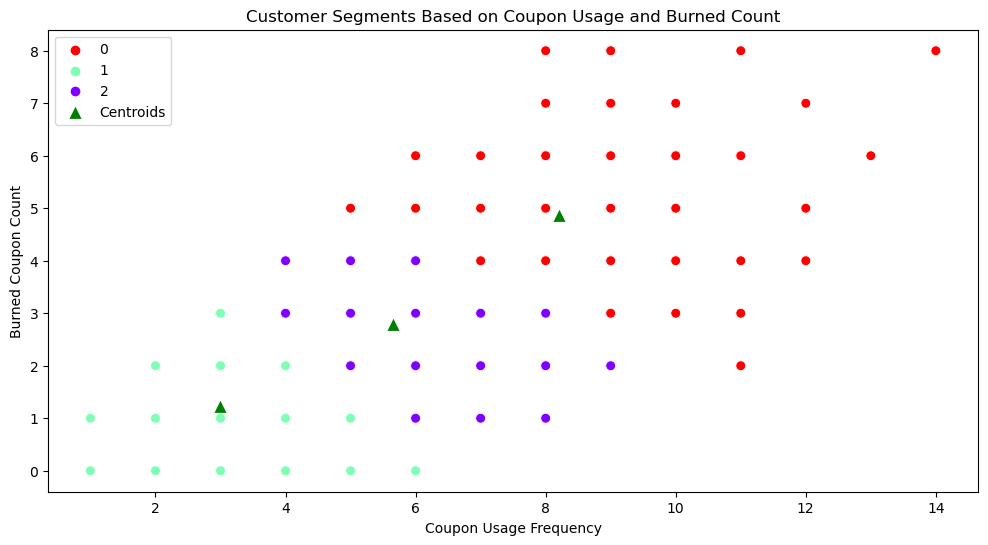

In [21]:
# Plot the data points and centroids
plt.figure(figsize=(12, 6))
sns.scatterplot(data=segmentation_data, 
                x='coupon_usage_frequency', 
                y='burned_coupon_count', 
                hue='cluster', 
                palette='rainbow_r', 
                s=50)

# Plot the centroids on the original scale
sns.scatterplot(data=centroids_df, 
                x='coupon_usage_frequency', 
                y='burned_coupon_count', 
                color='green', 
                s=100, 
                label='Centroids', 
                marker='^')

plt.title('Customer Segments Based on Coupon Usage and Burned Count')
plt.xlabel('Coupon Usage Frequency')
plt.ylabel('Burned Coupon Count')
plt.legend()
plt.show()

- Cluster 0 (Red) customers in this cluster are heavy coupon users, as they burn a lot of coupons and use them frequently.
- Cluster 1 (Light Blue) comprises customers who rarely use coupons, with lower coupon frequency and burned counts.
- Cluster 2 (Purple) is in between, where customers use coupons more moderately.

### 6. Segment Analysis

In [22]:
segment_analysis = segmentation_data.groupby('cluster').agg({
    'coupon_usage_frequency': 'mean',
    'burned_coupon_count': 'mean',
    'gender_name': lambda x: x.mode()[0],  # Most common gender
    'city_name': lambda x: x.mode()[0]     # Most common city
}).reset_index()

segment_analysis

,cluster,coupon_usage_frequency,burned_coupon_count,gender_name,city_name
0,0,8.206704,4.877095,Male,Port Said
1,1,2.997462,1.228426,Male,Damanhur
2,2,5.649038,2.786058,Female,Giza


#### Key Insights:

1. **Cluster 0:**
- **High coupon usage frequency** and **high burned coupon count**.
- Predominantly **Male** from **Port Said**.
- This group represents loyal and engaged customers. Offering additional **loyalty rewards or exclusive coupons** would likely increase their satisfaction and loyalty.

2. **Cluster 1:**
- **Low coupon usage frequency** and **low burned coupon count**.
- Predominantly **Male** from **Damanhur**.
- This group shows low engagement with coupons. Targeted **promotional campaigns** or **re-engagement strategies** (such as introductory offers or first-time coupon use bonuses) could help increase their activity.

3. **Cluster 2:**

- **Moderate coupon usage frequency** and **moderate burned coupon count**.
- Predominantly **Female** from **Giza**.
- This group is moderately engaged. **Retention-focused offers**, such as time-limited discounts or combo offers, may help maintain and even increase their engagement.

#### Author: Nahla Mohamed